In [44]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
import tensorflow as tf
import datetime, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

In [46]:
print(tf.__version__)

2.3.0


In [47]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [48]:
covid19_data = pd.read_csv('covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
covid19_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


<AxesSubplot:xlabel='Date', ylabel='Confirmed'>

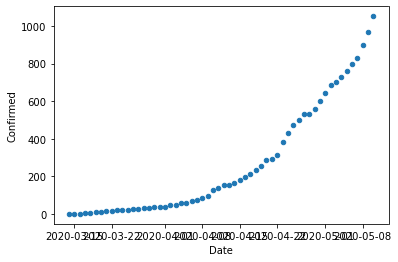

In [49]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed")

In [50]:
GT_confirmed.head(20)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
13851,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0,0
14115,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0,0
14379,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,1,0
14643,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1,0
14907,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1,0
15171,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9,1,0
15435,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12,1,0
15699,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17,1,0
15963,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,1,0
16227,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,1,0


<AxesSubplot:xlabel='Date', ylabel='ln(confirmed)'>

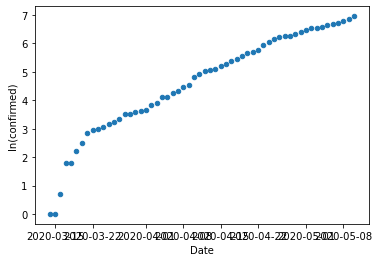

In [51]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

<AxesSubplot:xlabel='Date', ylabel='ln(confirmed)'>

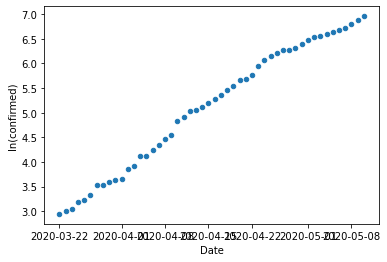

In [54]:
GT_confirmed_post24 = GT_confirmed[(GT_confirmed.Date >= '2020-03-22') & (GT_confirmed.Date < '2020-05-30')].copy()
GT_confirmed_post24.plot.scatter(x = "Date",y="ln(confirmed)")


In [55]:
start_date = GT_confirmed_post24.Date.min()
finish_date = GT_confirmed_post24.Date.max()
print(start_date, finish_date)
start_date = GT_confirmed_post24.Date.min()
GT_confirmed_post24["n_day"] = (GT_confirmed_post24.Date - start_date).dt.days


2020-03-22 00:00:00 2020-05-10 00:00:00


<AxesSubplot:xlabel='n_day', ylabel='ln(confirmed)'>

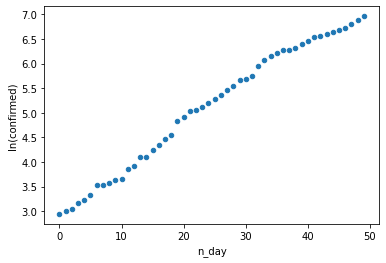

In [56]:
GT_confirmed_post24.plot.scatter(x = "n_day",y="ln(confirmed)")

In [66]:
def compute_prediction(X, params):
    ## add a column of one's to add the bias (b) in the same vectorize operation
    with tf.name_scope("Model"):
        padding = tf.constant([[0,0],[1, 0]], name="Padding")
        X_with_bias = tf.pad(X, padding, "CONSTANT", constant_values=1, name="PreparedData")
        model = tf.linalg.matmul(X_with_bias, params, name="Predict")
    return model

def compute_mse(y, y_hat):
    with tf.name_scope("Cost"):
        diff = tf.math.square(tf.math.subtract(y, y_hat))
        mse = 0.5 * tf.reduce_mean(diff, name="MSE")
        mse_summary = tf.summary.scalar(name="MSE_Summary", tensor=mse)
    return mse, mse_summary

def build_linear_model_graph(tensor_x, tensor_y, params, lr=0.001):
    prediction = compute_prediction(tensor_x, params)
    mse, mse_summary = compute_mse(tensor_y, prediction)
    with tf.name_scope("GradieDescent"):
        gradient = tf.gradients(mse, [params], name="Gradient")
        update_params = tf.assign(params, params - lr * gradient[0], name="UpdateParams")
    return prediction, update_params, params, mse, mse_summary

def fit(X, Y, batch_size, epochs=100, lr=0.001, print_n=10, logs_path='./logs/graph_'):
    tf.reset_default_graph()
    params = tf.get_variable("Params", dtype=tf.float32, shape=[2, 1],initializer=tf.zeros_initializer())
    tensor_x = tf.placeholder(tf.float32, [None,1], name="X")
    tensor_y = tf.placeholder(tf.float32, [None,1], name="Y")
    get_prediction, update_params, params, mse, mse_summary = build_linear_model_graph(tensor_x, tensor_y, params, lr)
    n = X.shape[0] // batch_size
    final_tetha = None
    path = f"{logs_path}batch_size_{batch_size}_lr_{lr}_{datetime.today().strftime('%Y%m%d-%H%M%S')}"
    with tf.train.MonitoredSession() as session:
        with tf.summary.FileWriter(path, session.graph) as train_writer:
            for epoch in range(epochs): 
                for i in range(n):
                    start, end = i * batch_size, (i+1) * batch_size
                    x_mbatch = np.array(X[start:end,]).reshape(-1,1)
                    y_mbatch = np.array(Y[start:end]).reshape(-1,1)
                    feed_dict = { tensor_x: x_mbatch, tensor_y: y_mbatch}
                    _, theta = session.run([update_params, params], feed_dict=feed_dict)
                if (epoch + 1) % print_n == 0:
                    feed_dict = { tensor_x: np.array(X).reshape(-1,1), tensor_y: np.array(Y).reshape(-1,1) }
                    e_summary, error =  session.run([mse_summary, mse], feed_dict = feed_dict)
                    train_writer.add_summary(e_summary, epoch)
            final_theta = session.run(params, feed_dict=feed_dict)
    def predict(x): 
        return compute_prediction(x, params)
    return final_theta, predict

In [67]:
x_test = [(datetime.strptime("2020-05-30", '%Y-%m-%d') - start_date).days]
x_test

[69]

In [68]:
%tensorboard --logdir logs
x_train, y_train = GT_confirmed_post24["n_day"], GT_confirmed_post24["ln(confirmed)"]
theta, predict = fit(x_train, y_train, batch_size=10, epochs=1000, lr=0.001, print_n=20)


Reusing TensorBoard on port 6006 (pid 12700), started 0:04:33 ago. (Use '!kill 12700' to kill it.)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[8.279983]]


In [70]:
with tf.Session() as session:
    y_estimates = session.run(compute_prediction(np.array(x_test).reshape(-1,1).astype('float32'), theta))
    print(np.exp(y_estimates))

[[3944.1257]]
